In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OrdinalEncoder,  OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Loading data

In [3]:
url= "https://raw.githubusercontent.com/nithinpradeep38/datasets/main/Train.csv"

In [4]:
data= pd.read_csv(url)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
data.shape

(8523, 12)

We have 12 variables. 11 independent variables and 1 dependent variable (Item Outlet sales).

In [6]:
for col in data.columns:
    print(f"{col}: {data[col].dtype}")

Item_Identifier: object
Item_Weight: float64
Item_Fat_Content: object
Item_Visibility: float64
Item_Type: object
Item_MRP: float64
Outlet_Identifier: object
Outlet_Establishment_Year: int64
Outlet_Size: object
Outlet_Location_Type: object
Outlet_Type: object
Item_Outlet_Sales: float64


We have 11 independent variables out of which 4 are numerical columns and 7 are categorical columns. The output variable is a numerical column which makes this a **regression problem.**

In [7]:
#Let us separate the categorial columns.
cat_col= [col for col in data.columns if data[col].dtype== 'object']
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [8]:
num_col= [col for col in data.columns if data[col].dtype!= 'object']
num_col

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [9]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We see 1463 values missing in Item_weight column and 2410 values missing in Outlet_size column.

#### Unique values for the categorical columns

In [10]:
for col in cat_col:
    print(f"{col}: {data[col].nunique()}")

Item_Identifier: 1559
Item_Fat_Content: 5
Item_Type: 16
Outlet_Identifier: 10
Outlet_Size: 3
Outlet_Location_Type: 3
Outlet_Type: 4


## Checking distributions

### Item Weight

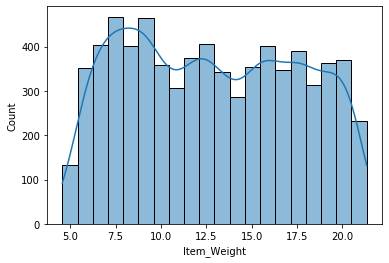

In [11]:
sns.histplot(data['Item_Weight'], kde= True, bins= 20)
plt.show()

In [12]:
np.round(data['Item_Weight'].mean(),2)

12.86

The mean weight of items is 12.86 and the weights range between 5 to 20 kgs.

### Item visibility

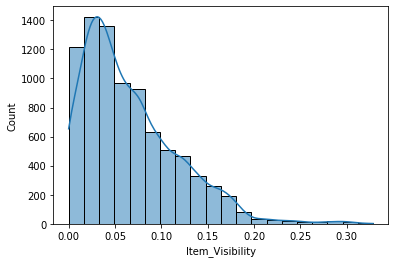

In [13]:
sns.histplot(data['Item_Visibility'], kde= True, bins= 20)
plt.show()

Most items have low visibility followed by outliers with high visibility. It is a positively skewed distribution.

### Item_MRP

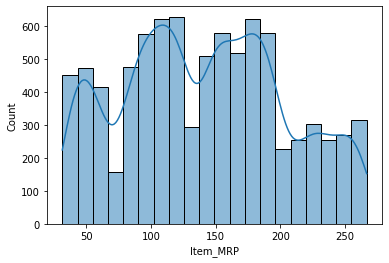

Range of MRP is (31.29, 266.8884)


In [14]:
sns.histplot(data['Item_MRP'], kde= True, bins= 20)
plt.show()
print(f"Range of MRP is ({data['Item_MRP'].min()}, {data['Item_MRP'].max()})")

Prices are clustered at around 50, 100 and 175

### Outlet establishment year


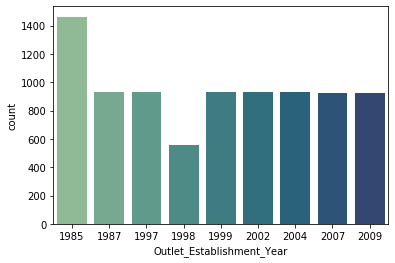

In [15]:
sns.countplot(x= 'Outlet_Establishment_Year',data= data, palette= 'crest')
plt.show()

The most number of outlets were opened up in 1985 (~1400). In 1998 there was a big dip. The rest of the years had same or similar number of outlets established.

### Item fat content

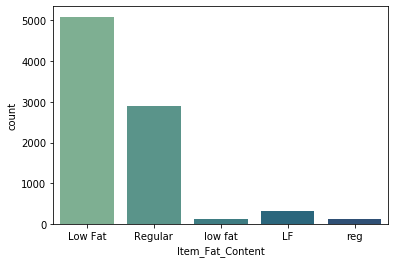

In [16]:
sns.countplot(x='Item_Fat_Content', data= data , palette='crest')
plt.show()

Majority of the data points have either **Low fat** or **Regular** as the Item_fat_content. 

**low fat** and **LF** may just be **Low fat**. To reduce cardinality, we can map these to Low fat category.
Similarly, **reg** can be renamed as **Regular**.

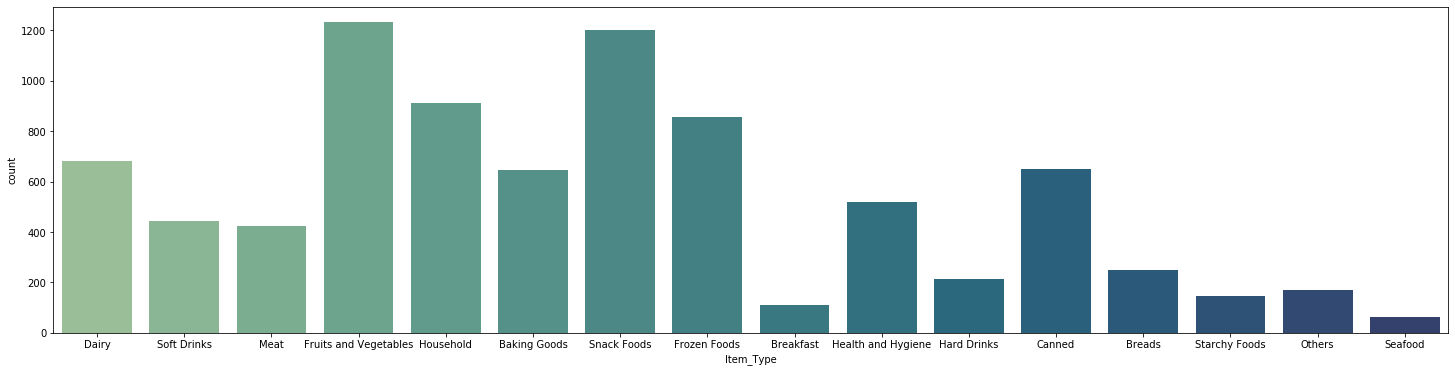

In [17]:
plt.figure(figsize= (25,6))
sns.countplot(x='Item_Type', data= data , palette='crest')
plt.show()

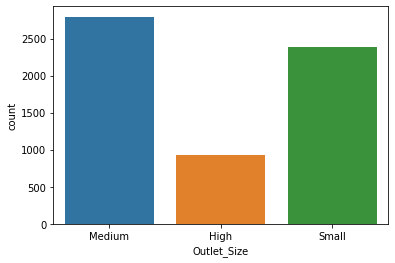

In [18]:
sns.countplot(x='Outlet_Size', data=data)
plt.show()

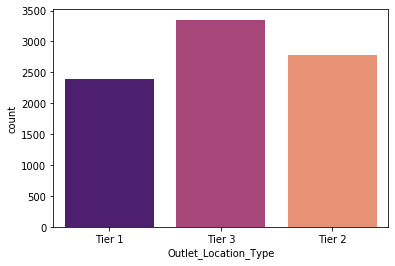

In [19]:
sns.countplot(x='Outlet_Location_Type', data=data, palette= 'magma')
plt.show()

### Data Processing

The item_identifier column has 1559 unique values. Such high cardinality is undesirable. So we will try to transform this column to have a lower cardinality. Let us first inspect this.

#### Treating high cardinality and fixing duplicate labels

In [20]:
data['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

The first two digits maybe indicative of a sub-category. Let us inspect the same.

In [21]:
first_two= set(data['Item_Identifier'].str[:2])
first_two

{'DR', 'FD', 'NC'}

The first two digits of item identifier are either of DR, FD or NC. Let us inspect the sub-set of data individually for these.

In [22]:
data[data['Item_Identifier'].str[:2]=='DR']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
27,DRJ59,11.650,low fat,0.019356,Hard Drinks,39.1164,OUT013,1987,High,Tier 3,Supermarket Type1,308.9312
34,DRH01,17.500,Low Fat,0.097904,Soft Drinks,174.8738,OUT046,1997,Small,Tier 1,Supermarket Type1,2085.2856
37,DRZ11,8.850,Regular,0.113124,Soft Drinks,122.5388,OUT018,2009,Medium,Tier 3,Supermarket Type2,1609.9044
...,...,...,...,...,...,...,...,...,...,...,...,...
8484,DRJ49,6.865,Low Fat,0.000000,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8506,DRF37,17.250,Low Fat,0.084676,Soft Drinks,263.1910,OUT018,2009,Medium,Tier 3,Supermarket Type2,3944.8650


In [23]:
data[data['Item_Identifier'].str[:2]=='FD']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
...,...,...,...,...,...,...,...,...,...,...,...,...
8515,FDH24,20.700,Low Fat,0.021518,Baking Goods,157.5288,OUT018,2009,Medium,Tier 3,Supermarket Type2,1571.2880
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850


In [24]:
data[data['Item_Identifier'].str[:2]=='NC']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
16,NCB42,11.80,Low Fat,0.008596,Health and Hygiene,115.3492,OUT018,2009,Medium,Tier 3,Supermarket Type2,1621.8888
22,NCB30,14.60,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
25,NCD06,13.00,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
31,NCS17,18.60,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009,Medium,Tier 3,Supermarket Type2,2741.7644
...,...,...,...,...,...,...,...,...,...,...,...,...
8500,NCQ42,20.35,Low Fat,0.000000,Household,125.1678,OUT017,2007,NaN,Tier 2,Supermarket Type1,1907.5170
8502,NCH43,8.42,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8516,NCJ19,18.60,Low Fat,0.118661,Others,58.7588,OUT018,2009,Medium,Tier 3,Supermarket Type2,858.8820


It is clear from the sub-sets of data that 'DR' represents items that are 'drinks', 'FD' represents items that are 'food' and 'NC' represents items that are 'non consumables'.

So as a data pre-processing step, we can map this column to represent these three categories thereby reducing cardinality of this column.

In [25]:
data['Item_Identifier']= data['Item_Identifier'].apply(lambda x:x[0:2]).map({'FD': "Food", 'DR': 'Drinks', 'NC': 'Non Consumable'})

In [26]:
data['Item_Fat_Content']= data['Item_Fat_Content'].map({'Low Fat': 'Low Fat', 'Regular': 'Regular', 'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

In [27]:
data['Item_Fat_Content'].unique() #converted the column to these two levels.

array(['Low Fat', 'Regular'], dtype=object)

### Imputation

In [28]:
num_col.remove('Item_Outlet_Sales')
num_col

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [29]:
numerical_imputer= SimpleImputer(strategy= 'median')
categorical_imputer= SimpleImputer(strategy= 'most_frequent')

In [30]:
data[num_col]= numerical_imputer.fit_transform(data[num_col])
data[cat_col]= categorical_imputer.fit_transform(data[cat_col])

In [31]:
data.isna().sum() #imputation performed successfully

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Plotting relationship with target variable

In [32]:
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [33]:
data.groupby('Item_Identifier')['Item_Outlet_Sales'].mean()

Item_Identifier
Drinks            1997.333337
Food              2215.354223
Non Consumable    2142.721364
Name: Item_Outlet_Sales, dtype: float64

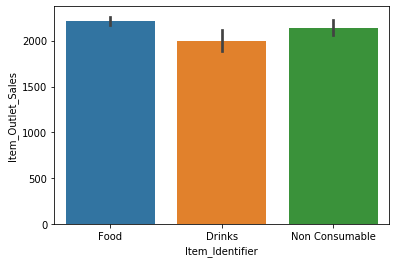

In [34]:
#The average sales across different item types is quite even

sns.barplot(x='Item_Identifier', y='Item_Outlet_Sales', data=data)
plt.show()

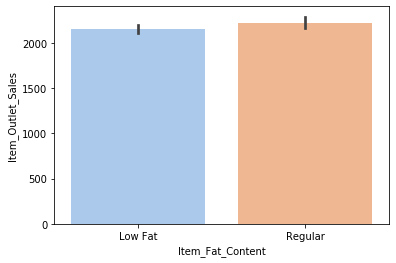

In [35]:
sns.barplot(x = 'Item_Fat_Content',y = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

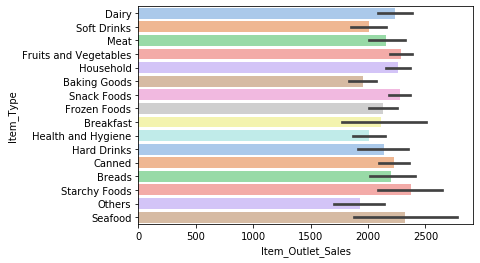

In [36]:
sns.barplot(y = 'Item_Type',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

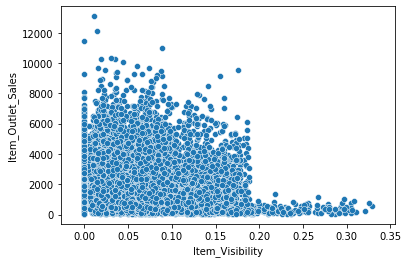

In [37]:
sns.scatterplot(x = 'Item_Visibility',y = 'Item_Outlet_Sales',data=data)
plt.show()

Till a visibility level of 0.2, the sales are not affected strongly by visibility. Beyond a visibility of 0.2, the sales are quite low.

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self, year=2022):
        self.year= year
        
    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y= None):
       # try:
            if 'Outlet_Establishment_Year' in X.columns:
                X['Outlet_Establishment_Year']= X["Outlet_Establishment_Year"].apply(lambda x: self.year - x)
                
            return X['Outlet_Establishment_Year']
       # exception